In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

from models.unet import Unet

import matplotlib.pyplot as plt
import numpy as np

## Set up

In [2]:
class CFG:
    # dataset
    batch_size = 4
    
    # noise
    B_0 = 1e-4
    B_T = 2e-2
    T = 500
    schedule_type = 'cosine'
    s = 0.008

## Dataset

In [3]:
from torch.utils.data import DataLoader
from data.dataset import CIFAR10_Dataset

batch_size = CFG.batch_size
train = CIFAR10_Dataset()
train_loader = DataLoader(train, shuffle=True, batch_size=batch_size)

Files already downloaded and verified


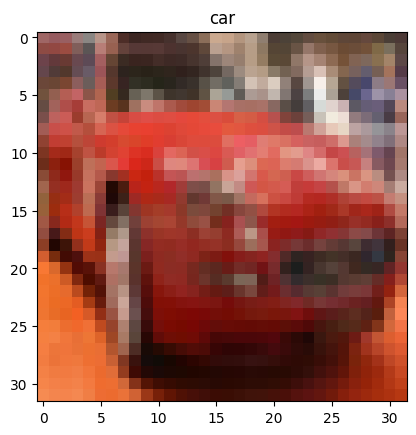

In [4]:
from utils.utils import show_image

image, label = train[5]
show_image(image, train.classes[label])

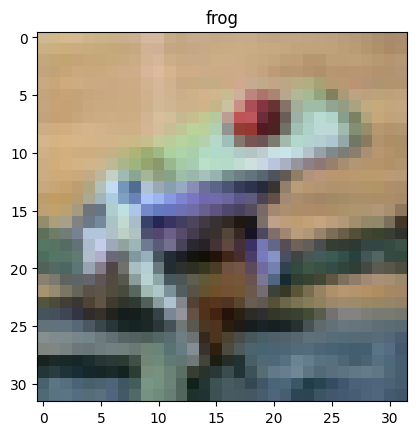

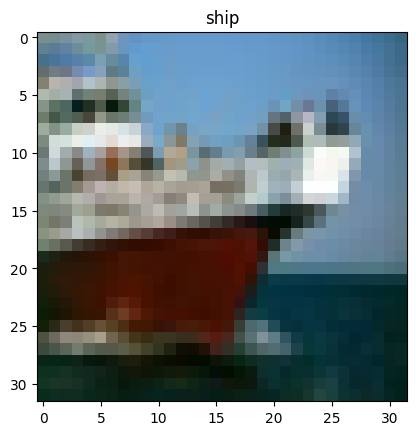

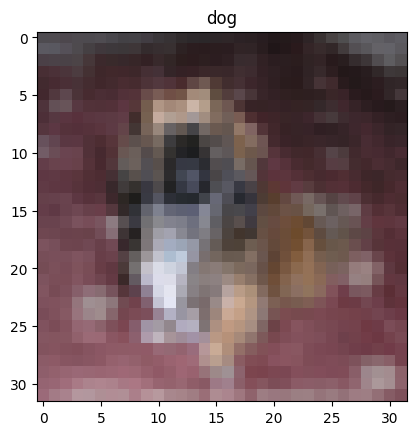

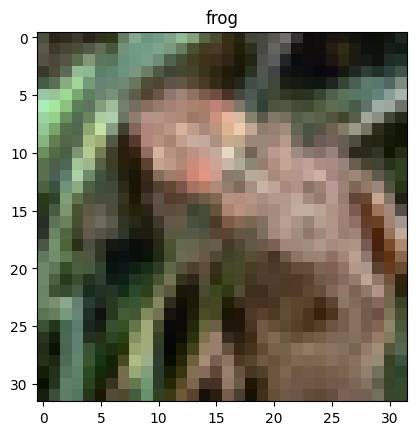

In [5]:
images, labels = next(iter(train_loader))
for image, label in zip(images, labels):
    show_image(image, train.classes[label])

## Noise

### Cosine Noise adder

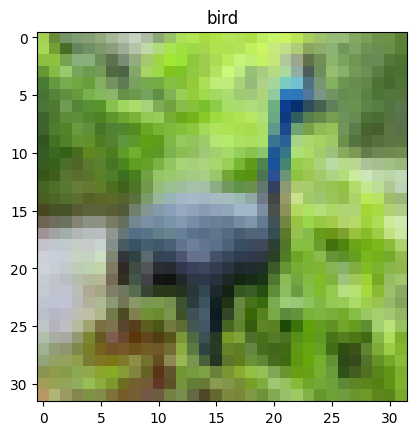

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


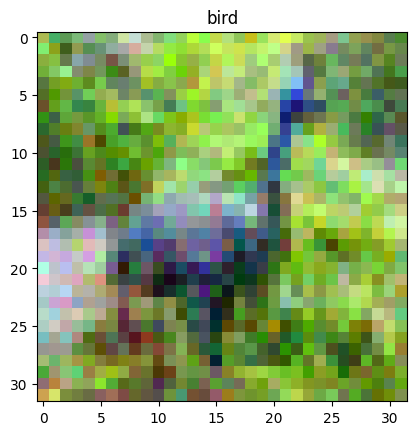

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


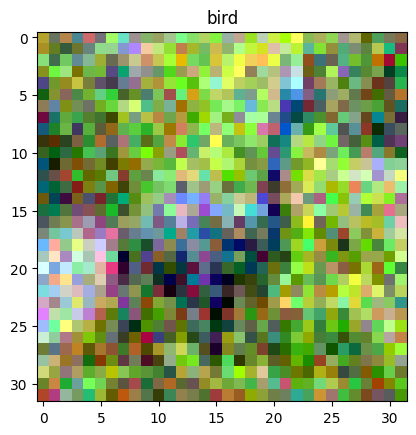

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


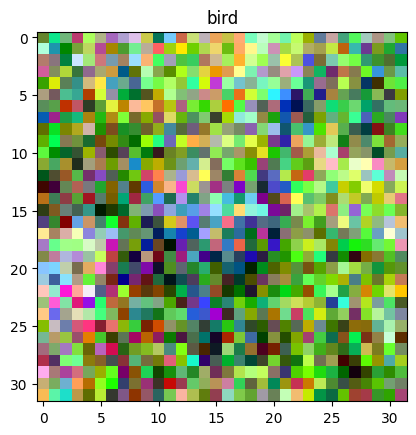

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


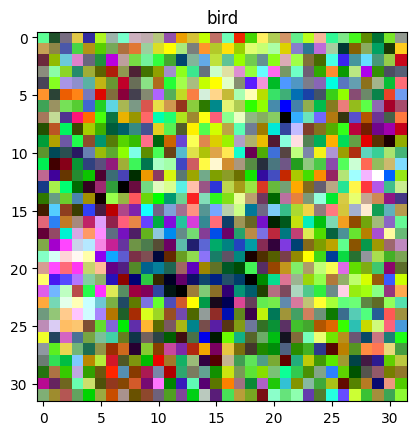

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


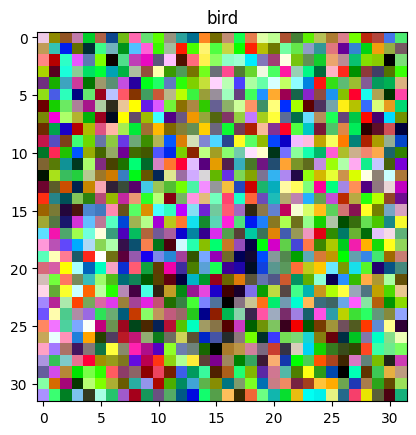

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


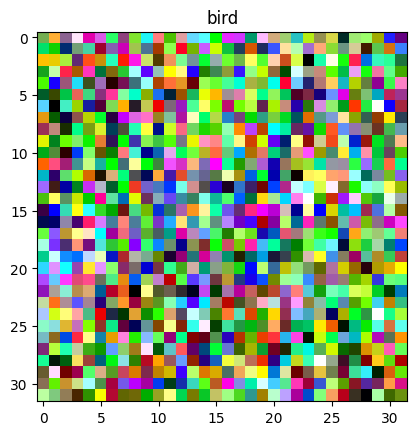

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


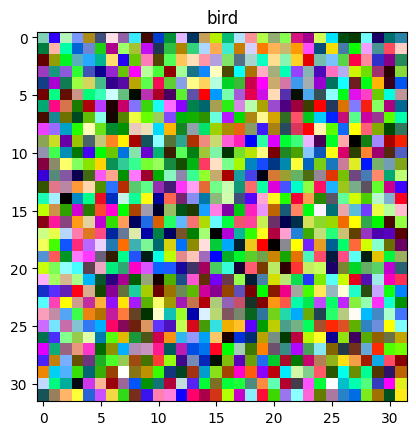

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


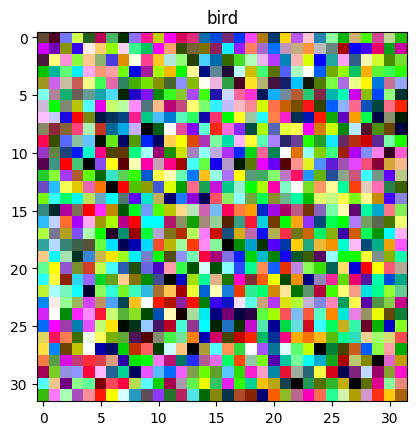

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


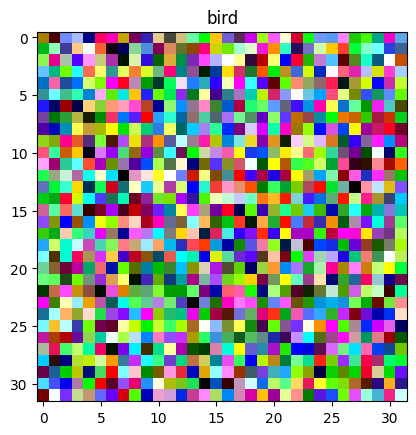

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


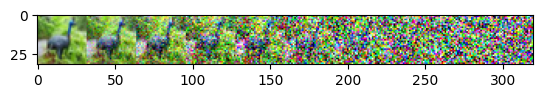

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


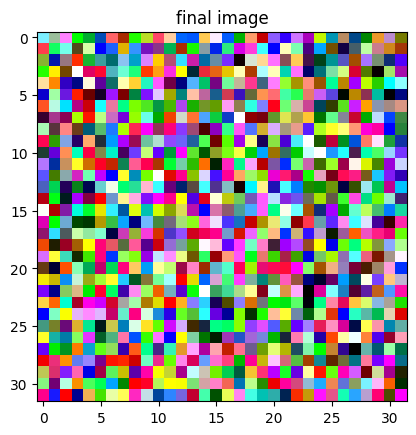

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


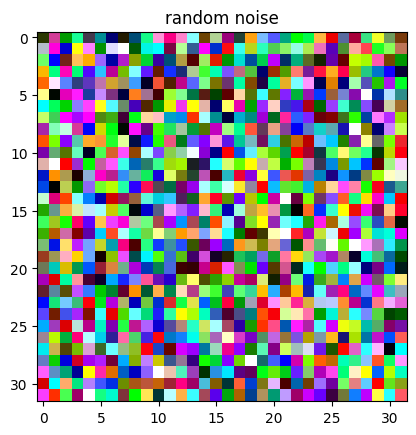

In [6]:
from utils.noise import CosineNoiseAdder

noise_adder = CosineNoiseAdder(CFG.T, CFG.s)

# Example input image
img, label = train[6]
full_img = torch.tensor([])

# Visualize the noise addition process
for t in torch.arange(0, CFG.T, 50):
    noisy_img, noise = noise_adder.image_at_time_step(img, t)
    full_img = torch.cat((full_img, noisy_img), 2)
    show_image(noisy_img, train.classes[label])
show_image(full_img)

final_noisy_img, noise = noise_adder.image_at_time_step(img, CFG.T - 1)
show_image(final_noisy_img, title="final image")

final_noise = torch.randn_like(img)
show_image(final_noise, title="random noise")

## Unet Model

In [7]:
train = CIFAR10_Dataset()
train_loader = DataLoader(train, shuffle=True, batch_size=16)
batch = next(iter(train_loader))
print(batch[0].shape)
# img, label = train[6]
imgs  = batch[0]

# fake data for testing
# imgs = torch.randn(16, 3, 128, 128)

Files already downloaded and verified
torch.Size([16, 3, 32, 32])


In [ ]:
net = Unet(16, 3, 8)
print("\n", net(imgs, torch.tensor([34])).shape)

start with shape torch.Size([16, 3, 32, 32])
after concatenating the timestep embedds : torch.Size([16, 19, 32, 32])
down block 0, with shape torch.Size([16, 19, 32, 32])
down block 1, with shape torch.Size([16, 16, 16, 16])
down block 2, with shape torch.Size([16, 32, 8, 8])
after bottleneck : shape = torch.Size([16, 64, 8, 8])
up block 0, with shape torch.Size([16, 64, 8, 8])
up block 1, with shape torch.Size([16, 32, 16, 16])
after final : shape = torch.Size([16, 3, 32, 32])

 torch.Size([16, 3, 32, 32])


## Noise Dataset

In [9]:
class NoiseDataset():
    def __init__(self, imgs_dataset, noise_schedule = None):
        self.imgs_dataset = imgs_dataset
        self.noise_schedule = noise_schedule if noise_schedule else CosineNoiseAdder()       

    def __getitem__(self, idx):
        img, label = self.imgs_dataset[idx]
        # t = torch.randint(self.noise_schedule.T, (1, ))
        t= 30
        noisy_img, noise = self.noise_schedule.image_at_time_step(img, t)
        return noisy_img, noise, t, label

    def __len__(self):
        return len(self.imgs_dataset)

## Training

In [10]:
max_time_steps = 1000
batch_size = 16

CIFAR10 = CIFAR10_Dataset()
CosineNoise = CosineNoiseAdder(max_time_steps)
train = NoiseDataset(CIFAR10, CosineNoise)

train_loader = DataLoader(train, shuffle=True, batch_size=batch_size)


noisy_img, noise, t, label = next(iter(train_loader))
print(noisy_img.shape, noise.shape, t.shape, label.shape)

Files already downloaded and verified
torch.Size([16, 3, 32, 32]) torch.Size([16, 3, 32, 32]) torch.Size([16]) torch.Size([16])


In [11]:
n_epochs = 50
batch_size = 16
lr = 1e-2

for epoch in range(n_epochs):
    for i, batch in enumerate(train_loader):
        print(batch[0].shape)
        break


torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 3